## Temporal properties of object selectivity

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

from scipy import stats
import statsmodels.api as sm

import pingouin as pg

import matplotlib as mpl
import matplotlib.pyplot as plt  

import seaborn as sns

from datetime import date
import time

from joblib import Parallel, delayed

import h5py

In [2]:
# no top and right spines in all plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [3]:
mother_path = Path('D:/Multi-modal project/')
fig_path = mother_path / 'analysis' / 'result' / 'figures'

### Parameter setting

In [4]:
gauss_sigma = 2

# colors for multimodal, vis-only, aud-only conditions
color = ['mediumorchid','cornflowerblue','lightcoral','gray']
color2 = ['cyan','magenta','gray']
linestyle = ['-',':']

today = str(date.today())

### Data preparation

In [5]:
save_path = mother_path /'analysis'/'result'/'4. Temporal patterns of object selectivity'/today

cell_path = mother_path/'analysis'/'result'/'zFR export'/'13-Apr-2022 (5 trials)'
cell_list = os.listdir(cell_path)

# load hdf5 files containing shuffled results
data_path = mother_path /'analysis'/'result'/'3. ANOVA'/'2023-06-14'
data2_path = mother_path /'analysis'/'result'/'3.1 Multiple linear regression'/'2023-06-14'
f = h5py.File(data_path/'2023-06-14_ANOVA_result.hdf5','r')
f2 = h5py.File(data2_path/'2023-06-14_multiple_regression_result.hdf5','r')

In [6]:
def h5_to_df(f):
    keys = list(f.keys())
    attributes = {}
    
    for key in keys:
        attributes[key] = dict(f[key].attrs.items())
    
    df = pd.DataFrame.from_dict(attributes, orient='index')
    df.index.name = 'key'
    df = df.reset_index()
    
    return df

In [7]:
df = h5_to_df(f2)
df = df[(df['Region']=='PER')&(df['Response cell']==0)]
df.reset_index(inplace=True,drop=True)

### Temporal patterns of object selectivity

In [8]:
object_bin_all = np.zeros((0,90))

for key in df['key']:    
    df.loc[df['key']==key,'peak_selectivity'] = np.max(f[f'{key}/anova_eta'])  
    df.loc[df['key']==key,'peak_selectivity_time'] = np.argmax(f[f'{key}/anova_eta'])*10
    df.loc[df['key']==key,'selectivity_duration'] = len(f[f'{key}/object_bin'])*10
    df.loc[df['key']==key,'selectivity_onset'] = np.min(f[f'{key}/object_bin'])*10
    
    object_bin = np.zeros((1,90))
    object_bin[0,f[f'{key}/object_bin']] = 1
    object_bin_all = np.append(object_bin_all, [object_bin[0]], axis=0)   
    
df['peak_selectivity_time_range'] = (df['peak_selectivity_time'] // 100) + 1
df['selectivity_onset_range'] = (df['peak_selectivity_time'] // 100) + 1
    
bin_sorted_peak = object_bin_all[np.argsort(df['peak_selectivity_time']),:]
bin_sorted_onset = object_bin_all[np.argsort(df['selectivity_onset']),:]

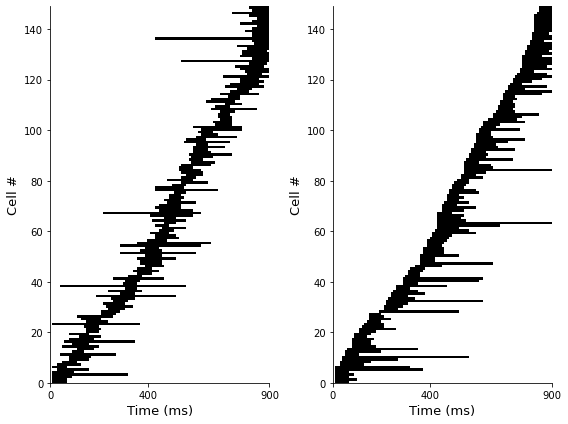

In [9]:
fig,ax = plt.subplots(1,2,figsize=(8,6))

ax[0].pcolor(bin_sorted_peak,cmap='binary')
ax[0].set_xticks([0,40,90])
ax[0].set_xticklabels([0,400,900])
ax[0].set_xlabel('Time (ms)',fontsize=13)
ax[0].set_ylabel('Cell #',fontsize=13)

ax[1].pcolor(bin_sorted_onset,cmap='binary')
ax[1].set_xticks([0,40,90])
ax[1].set_xticklabels([0,400,900])
ax[1].set_xlabel('Time (ms)',fontsize=13)
ax[1].set_ylabel('Cell #',fontsize=13)

plt.tight_layout()
#plt.savefig(fig_path / 'population_selectivity.png', dpi=300,facecolor='white')

K-S test with uniform distribution
KS statistic: 0.14290023376819244
P-value: 0.00405948307441261


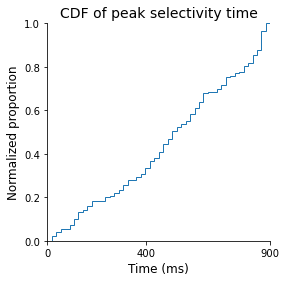

In [10]:
fig,ax = plt.subplots(figsize=(4,4))

ax.hist(df['peak_selectivity_time'], range=(0,900), bins=50, cumulative=1, histtype='step', density=True);

ax.set_ylim([0,1])
ax.set_xticks([0,400,900])
ax.set_xlim([0,900])
ax.set_ylabel('Normalized proportion',fontsize=12);
ax.set_xlabel('Time (ms)',fontsize=12);
ax.set_title('CDF of peak selectivity time',fontsize=14);

s,p = stats.kstest(df['peak_selectivity_time'], stats.uniform(loc=0, scale=890).cdf)
print('========================================================')
print("K-S test with uniform distribution")
print(f"KS statistic: {s}")
print(f"P-value: {p}")
print('========================================================')

K-S test with uniform distribution
KS statistic: 0.09632846427161468
P-value: 0.11786918285583936


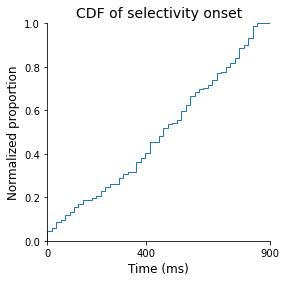

In [11]:
fig,ax = plt.subplots(figsize=(4,4))

ax.hist(df['selectivity_onset'], range=(0,900), bins=50, cumulative=1, histtype='step', density=True);

ax.set_ylim([0,1])
ax.set_xticks([0,400,900])
ax.set_xlim([0,900])
ax.set_ylabel('Normalized proportion',fontsize=12);
ax.set_xlabel('Time (ms)',fontsize=12);
ax.set_title('CDF of selectivity onset',fontsize=14);

s,p = stats.kstest(df['selectivity_onset'], stats.uniform(loc=10, scale=850).cdf)
print('========================================================')
print("K-S test with uniform distribution")
print(f"KS statistic: {s}")
print(f"P-value: {p}")
print('========================================================')

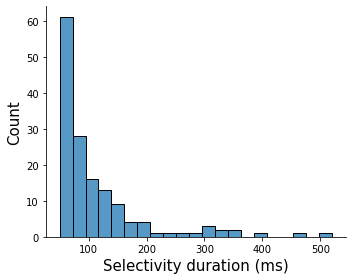

In [12]:
fig,ax = plt.subplots(figsize=(5,4))

sns.histplot(df['selectivity_duration'],ax=ax);
ax.set_xlabel('Selectivity duration (ms)',fontsize=15);
ax.set_ylabel('Count',fontsize=15);

plt.tight_layout()
#plt.savefig(fig_path / 'selectivity_duration_hist.png', dpi=300,facecolor='white')

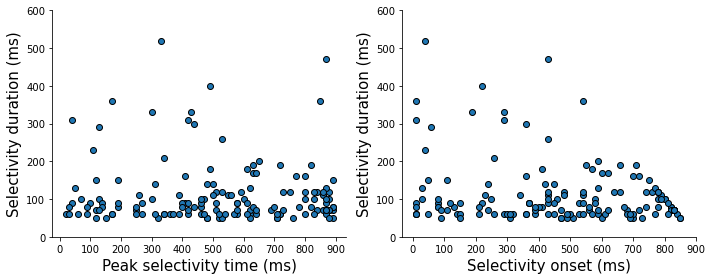

In [13]:
fig,ax = plt.subplots(1,2,figsize=(10,4))

ax[0].scatter(df['peak_selectivity_time'],df['selectivity_duration'],edgecolors='k')
ax[0].set_ylabel('Selectivity duration (ms)',fontsize=15)
ax[0].set_yticks(np.arange(0,700,100));
ax[0].set_ylim([0,600])
ax[0].set_xlabel('Peak selectivity time (ms)',fontsize=15)
ax[0].set_xticks(np.arange(0,1000,100));

ax[1].scatter(df['selectivity_onset'],df['selectivity_duration'],edgecolors='k')
ax[1].set_ylabel('Selectivity duration (ms)',fontsize=15)
ax[1].set_yticks(np.arange(0,700,100));
ax[1].set_xlabel('Selectivity onset (ms)',fontsize=15)
ax[1].set_xticks(np.arange(0,1000,100));

plt.tight_layout()
#plt.savefig(fig_path / 'time_duration_scatter.png', dpi=300,facecolor='white')

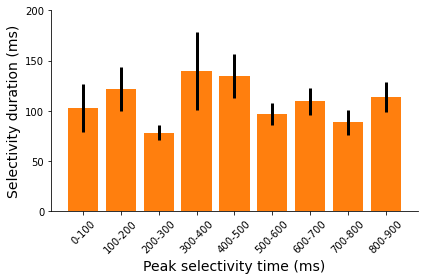

In [14]:
fig,ax = plt.subplots(figsize=(6,4))

x = range(9)
y = df.groupby('peak_selectivity_time_range').mean()['selectivity_duration']
yerr = df.groupby('peak_selectivity_time_range').sem()['selectivity_duration']

ax.bar(x=x, height=y, color='tab:orange')
ax.errorbar(x=x, y=y, yerr=yerr, fmt='none',color='black', linewidth=3)
ax.set_yticks(np.arange(0,210,50))
ax.set_ylabel('Selectivity duration (ms)',fontsize=14)
ax.set_xlabel('Peak selectivity time (ms)',fontsize=14)
ax.set_xticks(range(9))
ax.set_xticklabels(['0-100','100-200','200-300','300-400','400-500','500-600','600-700','700-800','800-900'])
ax.tick_params(axis='x',labelrotation=45);

pg.anova(data=df, dv='selectivity_duration', between='peak_selectivity_time_range', detailed=True)

plt.tight_layout()
#plt.savefig(fig_path / 'selectivity_duration_bar.png', dpi=300,facecolor='white')

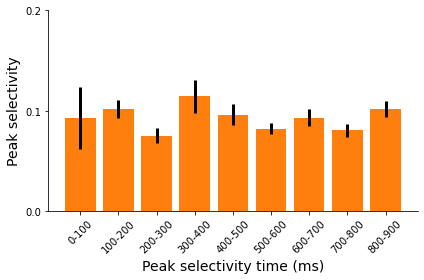

In [15]:
fig,ax = plt.subplots(figsize=(6,4))

x = range(9)
y = df.groupby('peak_selectivity_time_range').mean()['peak_selectivity']
yerr = df.groupby('peak_selectivity_time_range').sem()['peak_selectivity']

ax.bar(x=x, height=y, color='tab:orange')
ax.errorbar(x=x, y=y, yerr=yerr, fmt='none',color='black', linewidth=3)
ax.set_yticks(np.arange(0,0.3,0.1))
ax.set_ylabel('Peak selectivity',fontsize=14)
ax.set_xlabel('Peak selectivity time (ms)',fontsize=14)
ax.set_xticks(range(9))
ax.set_xticklabels(['0-100','100-200','200-300','300-400','400-500','500-600','600-700','700-800','800-900'])
ax.tick_params(axis='x',labelrotation=45);

pg.anova(data=df, dv='peak_selectivity', between='peak_selectivity_time_range', detailed=True)

plt.tight_layout()
#plt.savefig(fig_path / 'peak_selectivity_bar.png', dpi=300,facecolor='white')